In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import zscore, pearsonr, spearmanr

In [3]:
Fastq_samples = pd.read_csv("../code/config/samples.tsv", sep='\t', comment='#')
igsr_samples = pd.read_csv('../data/igsr_samples.tsv.gz', sep='\t', index_col=0)

polyA_samples = Fastq_samples.loc[Fastq_samples.Phenotype == 'Expression.Splicing'].IndID
YRI_samples = igsr_samples.loc[igsr_samples['Population code'] == 'YRI'].index

temp = '../code/QTLs/QTLTools/{Phenotype}/OnlyFirstRepsBasicUnstandardized.qqnorm.bed.gz'
temp_ = '../code/QTLs/QTLTools/{Phenotype}/OnlyFirstRepsUnstandardized.qqnorm.bed.gz'


polyA = pd.read_csv(temp.format(Phenotype = 'Expression.Splicing'), sep='\t', index_col=3)
chRNA = pd.read_csv(temp.format(Phenotype = 'chRNA.Expression.Splicing'), sep='\t', index_col=3)
ml30 = pd.read_csv(temp.format(Phenotype = 'MetabolicLabelled.30min'), sep='\t', index_col=3)
ml60 = pd.read_csv(temp.format(Phenotype = 'MetabolicLabelled.60min'), sep='\t', index_col=3)

h3k36me3 = pd.read_csv("../code/QTLs/QTLTools/H3K36ME3/OnlyFirstRepsUnstandardized.Last3K.qqnorm.bed.gz", 
                       sep='\t', index_col=3)


temp = '../code/QTLs/QTLTools/{Phenotype}/OnlyFirstRepsUnstandardized_AtTSS.qqnorm.bed.gz'
h3k27ac = pd.read_csv(temp.format(Phenotype = 'H3K27AC'), sep='\t', index_col=3)
h3k4me3 = pd.read_csv(temp.format(Phenotype = 'H3K4ME3'), sep='\t', index_col=3)
h3k4me1 = pd.read_csv(temp.format(Phenotype = 'H3K4ME1'), sep='\t', index_col=3)


In [7]:
shared_samples = h3k36me3.columns.intersection(YRI_samples).intersection(h3k4me3.columns).intersection(
    h3k27ac.columns).intersection(polyA.columns).intersection(chRNA.columns).intersection(
    ml30.columns).intersection(h3k36me3.columns)

In [8]:
expressed_genes = polyA.loc[polyA[polyA.columns[5:]].median(axis=1) > -2].index

In [10]:
all_RNAs = pd.Index(expressed_genes).intersection(ml30.index).intersection(ml60.index).intersection(h3k36me3.index) #+ lncRNA + snoRNA + list(eRNA) + list(cheRNA)# + introns

polyA_samples = polyA.columns.intersection(YRI_samples)
polyA_logRPKM = polyA.loc[all_RNAs, polyA_samples]
polyA_logRPKM.columns = ['polyA.' + x for x in polyA_samples]

chRNA_samples = chRNA.columns.intersection(YRI_samples)
chRNA_logRPKM = chRNA.loc[all_RNAs, chRNA_samples]
chRNA_logRPKM.columns = ['chRNA.' + x for x in chRNA_samples]

ml60_samples = ml60.columns.intersection(YRI_samples)
ml60_logRPKM = ml60.loc[all_RNAs, ml60_samples]
ml60_logRPKM.columns = ['ml60.' + x for x in ml60_samples]

ml30_samples = ml30.columns.intersection(YRI_samples)
ml30_logRPKM = ml30.loc[all_RNAs, ml30_samples]
ml30_logRPKM.columns = ['ml30.' + x for x in ml30_samples]

# ml60_samples = ml60.columns.intersection(YRI_samples)
# h3k4me3_logRPKM = h3k4me3.loc[all_RNAs, shared_samples]
# h3k4me3_logRPKM.columns = ['h3k4me3.' + x for x in shared_samples]

h3k36me3_samples = h3k36me3.columns.intersection(YRI_samples)
h3k36me3_logRPKM = h3k36me3.loc[all_RNAs, h3k36me3_samples]
h3k36me3_logRPKM.columns = ['h3k36me3.' + x for x in h3k36me3_samples]




# h3k27ac_logRPKM = h3k27ac.loc[all_RNAs, shared_samples]
# h3k27ac_logRPKM.columns = ['h3k27ac.' + x for x in shared_samples]


In [11]:
H3K4ME3_TSS = pd.read_csv('../code/featureCounts/H3K4ME3/Counts.txt',
                                 sep='\t', skiprows = 1)
H3K4ME3_names = [x.split('ME3/')[1].split('.1')[0] for x in H3K4ME3_TSS.columns if ('Alignments' in x)]

H3K4ME3 = pd.read_csv('../code/QTLs/QTLTools/H3K4ME3/CountsPeaksAtTSS.bed.gz',#'../../H3K4ME3.TSS.PeakCounts.bed.gz', 
                      sep='\t',
                     names = ['chrom', 'start', 'end', 'transcript_id', 'ensembl_id', 'strand',
                             'gene_id', 'chrom_', 'start_', 'end_', 'peak_id', 'peak_len',
                             'strand_'] + H3K4ME3_names + ['overlap_len'])
                     
H3K4ME3_samples = H3K4ME3.columns.intersection(YRI_samples)
H3K4ME3 = H3K4ME3.groupby(['ensembl_id', 'peak_id']).max()
H3K4ME3_counts = H3K4ME3.groupby('ensembl_id')[H3K4ME3_samples].sum()
h3k4me3_CPM = H3K4ME3_counts.divide(H3K4ME3_counts.sum(axis=0), axis=1)*1e6

h3k4me3_CPM = h3k4me3_CPM.loc[h3k4me3_CPM.median(axis=1) > 0]
h3k4me3_logRPKM = np.log(h3k4me3_CPM)
h3k4me3_logRPKM.columns = ['h3k4me3.' + x for x in h3k4me3_logRPKM.columns]


In [12]:
H3K27AC_TSS = pd.read_csv('../code/featureCounts/H3K27AC/Counts.txt',
                                 sep='\t', skiprows = 1)
H3K27AC_names = [x.split('27AC/')[1].split('.1')[0] for x in H3K27AC_TSS.columns if ('Alignments' in x)]

H3K27AC = pd.read_csv('../code/QTLs/QTLTools/H3K27AC/CountsPeaksAtTSS.bed.gz',#'../../H3K27AC.TSS.PeakCounts.bed.gz', 
                      sep='\t',
                     names = ['chrom', 'start', 'end', 'transcript_id', 'ensembl_id', 'strand',
                             'gene_id', 'chrom_', 'start_', 'end_', 'peak_id', 'peak_len',
                             'strand_'] + H3K27AC_names + ['overlap_len'])
                     
H3K27AC_samples = H3K27AC.columns.intersection(YRI_samples)
H3K27AC = H3K27AC.groupby(['ensembl_id', 'peak_id']).max()
H3K27AC_counts = H3K27AC.groupby('ensembl_id')[H3K27AC_samples].sum()
h3k27ac_CPM = H3K27AC_counts.divide(H3K27AC_counts.sum(axis=0), axis=1)*1e6

h3k27ac_CPM = h3k27ac_CPM.loc[h3k27ac_CPM.median(axis=1) > 0]
h3k27ac_logRPKM = np.log(h3k27ac_CPM)
h3k27ac_logRPKM.columns = ['h3k27ac.' + x for x in h3k27ac_logRPKM.columns]


In [13]:
all_phenotypes = pd.concat([h3k27ac_logRPKM,
                            h3k4me3_logRPKM, 
                            h3k36me3_logRPKM, 
                            chRNA_logRPKM, 
                            ml30_logRPKM, ml60_logRPKM, polyA_logRPKM], axis=1)

pheno_corr = all_phenotypes.corr()

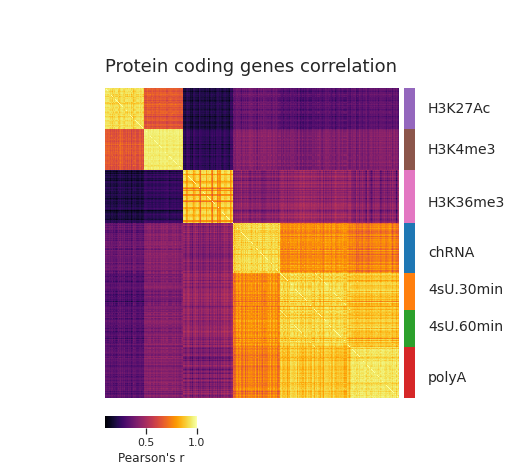

In [14]:
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})


col_list = plt.cm.tab10(range(10))
colores = [col_list[4]]*len(h3k27ac_logRPKM.columns)
colores += [col_list[5]]*len(h3k4me3_logRPKM.columns)
colores += [col_list[6]]*len(h3k36me3_logRPKM.columns)
colores += [col_list[0]]*len(chRNA_logRPKM.columns)
colores += [col_list[1]]*len(ml30_logRPKM.columns)
colores += [col_list[2]]*len(ml60_logRPKM.columns)
colores += [col_list[3]]*len(polyA_logRPKM.columns)



g = sns.clustermap(pheno_corr, row_colors = colores, row_cluster=False, col_cluster=False,
              cmap='inferno', cbar_kws={'label': "Pearson's r", "orientation": "horizontal"},
                  figsize=(7.5, 7.5))


g.ax_heatmap.set_xticklabels([])
g.ax_heatmap.set_yticklabels([])
g.ax_heatmap.tick_params(right=False, bottom=False)

n = len(pheno_corr)
m = len(h3k27ac_logRPKM.columns)
g.ax_heatmap.text(n*1.1, m-30, 'H3K27Ac', size=14, )
m += len(h3k4me3_logRPKM.columns)
g.ax_heatmap.text(n*1.1, m-30, 'H3K4me3', size=14, )
m += len(h3k36me3_logRPKM.columns)
g.ax_heatmap.text(n*1.1, m-30, 'H3K36me3', size=14,)
m += len(chRNA_logRPKM.columns)
g.ax_heatmap.text(n*1.1, m-30, 'chRNA', size=14, )
m += len(ml30_logRPKM.columns)
g.ax_heatmap.text(n*1.1, m-30, '4sU.30min', size=14,)
m += len(ml60_logRPKM.columns)
g.ax_heatmap.text(n*1.1, m-30, '4sU.60min', size=14, )
m += len(polyA_logRPKM.columns)
g.ax_heatmap.text(n*1.1, m-30, 'polyA', size=14, )

box_heatmap = g.ax_heatmap.get_position()
box_cbar = g.ax_cbar.get_position()

g.ax_cbar.set_position([box_heatmap.min[0], box_heatmap.max[1]-0.63, box_cbar.max[0]+0.1, 
                        box_cbar.max[0]/3])

box = g.ax_row_colors.get_position()

g.ax_heatmap.text(0, -30, 'Protein coding genes correlation', size=18)

# g.ax_col_colors.set_position([box_heatmap.max[0], box.y0, box.width*1.5, box.height])
g.ax_row_colors.set_position([box_heatmap.max[0]+0.01, box_heatmap.min[1], box.width, box.height])


plt.show()
# plt.savefig('../plots/correlation.heatmap.png', dpi=300, bbox_inches='tight',)

In [15]:
h3k36me3_logRPKM

,h3k36me3.NA19137,h3k36me3.NA19152,h3k36me3.NA19153,h3k36me3.NA19171,h3k36me3.NA19200,h3k36me3.NA19160,h3k36me3.NA19092,h3k36me3.NA19210,h3k36me3.NA19119,h3k36me3.NA18909,...,h3k36me3.NA18910,h3k36me3.NA18876,h3k36me3.NA19108,h3k36me3.NA19141,h3k36me3.NA19098,h3k36me3.NA19213,h3k36me3.NA19121,h3k36me3.NA19107,h3k36me3.NA19118,h3k36me3.NA19143
pid,,,,,,,,,,,,,,,,,,,,,
ENSG00000188976.11,6.672897,6.552901,6.632529,6.512738,6.331402,6.349461,6.300709,6.130498,6.092941,6.533339,...,6.652795,6.450250,6.704941,6.334963,6.213852,6.279365,6.036019,6.098379,6.202115,5.912326
ENSG00000187961.14,6.021709,5.776996,6.187486,5.841532,6.163870,5.623473,5.709684,5.783949,5.478799,5.921560,...,5.960704,6.120956,5.978125,6.104209,5.327364,5.723131,5.801624,5.332139,5.773590,5.564522
ENSG00000187608.10,4.858387,4.455788,4.671100,4.993902,3.999449,4.732377,4.198716,3.693585,4.387545,4.216989,...,5.162479,5.145984,5.265461,4.241142,4.921584,5.417145,5.442216,5.589528,4.983580,4.724440
ENSG00000188157.15,6.931124,6.499273,6.724026,6.921238,5.930215,6.505963,6.453921,6.466287,5.738765,6.248833,...,6.985817,6.849665,7.119915,6.168776,6.327036,6.293716,6.468874,6.165033,6.342353,6.564244
ENSG00000131591.17,5.787794,5.954858,6.137989,5.886036,5.531803,5.716884,5.250441,5.421516,5.288780,5.551318,...,6.179100,5.798345,5.989556,5.999728,5.123105,5.062222,5.521618,4.976841,5.470456,5.672734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000130653.16,4.684006,4.467006,5.068371,4.878494,5.266259,4.607840,4.443604,4.252358,4.227228,4.837982,...,5.435607,4.878202,4.821097,4.842405,4.921584,4.723629,4.299989,4.316129,5.052803,4.106063
ENSG00000148399.13,5.825626,5.851649,5.978415,6.011862,5.915218,5.828065,5.325694,5.510288,5.906982,5.732859,...,6.010909,5.924808,5.714408,5.674161,5.576619,5.390685,5.801624,5.561525,5.622400,5.583130
ENSG00000165724.6,6.393215,6.388593,6.545721,6.481437,6.586199,6.339705,5.902266,5.919790,5.958961,6.348346,...,6.329715,6.231614,6.314435,6.364281,6.340579,5.845081,5.691479,5.771667,6.096789,5.447529


In [18]:
plt.scatter(h3k27ac_logRPKM['h3k27ac.NA19206'],
            h3k36me3_logRPKM['h3k27ac.NA19206'])

ensembl_id
ENSG00000000419.12    3.532003
ENSG00000000457.14    5.279656
ENSG00000000460.17    4.713387
ENSG00000000938.13    5.018441
ENSG00000001036.14    3.474546
                        ...   
ENSG00000288597.1     4.510291
ENSG00000288600.1    -0.652589
ENSG00000288601.1    -0.364907
ENSG00000288602.1     4.062929
ENSG00000288604.1     1.937678
Name: h3k27ac.NA19206, Length: 23913, dtype: float64

In [191]:
bed12_names = ['chrom', 'start', 'end', 'gene', 'score', 'strand',
               'thickStart', 'thickEnd', 'itemRgb', 'blockCount',
               'blockSizes', 'blockStarts'
              ]
X = pd.read_csv('../code/ExpressionAnalysis/polyA/ExpressedGeneList.bed12', sep='\t',
               names = bed12_names)

In [192]:
CDS_length = []
for idx, row in X.iterrows():
    blockSizes = np.sum([int(x) for x in row.blockSizes.rstrip(',').split(',')])
    CDS_length.append(blockSizes)
    
X['CDS_length'] = CDS_length
X['gene_length'] = X.end - X.start


In [199]:
n = 3500
X.sort_values('CDS_length')[:n][bed12_names]
X.sort_values('CDS_length')[n*3:][bed12_names]

,chrom,start,end,gene,score,strand,thickStart,thickEnd,itemRgb,blockCount,blockSizes,blockStarts
11960,chr6,63521745,63583377,ENSG00000112245.12,0,+,63576880,63580174,0,8,"81,266,194,550,93,131,75,3321,","0,6073,10591,54690,56691,57152,57511,58311,"
3931,chr14,21476754,21499175,ENSG00000092203.15,0,+,21477278,21496606,0,10,"119,163,69,243,261,231,81,750,164,2630,","0,367,741,10696,11835,12418,15541,15753,18474,..."
3025,chr12,13044380,13083449,ENSG00000084444.14,0,+,13044403,13080630,0,13,"60,396,99,189,131,148,142,144,82,156,118,221,2...","0,11170,14070,17194,18464,22259,22774,23923,24..."
4796,chr15,89243948,89317261,ENSG00000140525.18,0,+,89247647,89316459,0,37,"85,103,73,131,157,58,42,124,86,127,93,137,181,...","0,3680,14755,16764,17636,17872,19470,19954,205..."
2362,chr11,59574397,59615774,ENSG00000110048.12,0,-,59576576,59615664,0,14,"2322,221,182,96,104,121,246,132,55,103,199,251...","0,2407,3751,5776,7053,19206,19612,26098,26421,..."
...,...,...,...,...,...,...,...,...,...,...,...,...
4280,chr14,90847860,91060641,ENSG00000100784.12,0,-,90872073,91060434,0,17,"24462,164,160,192,171,94,134,126,162,151,104,8...","0,25771,27340,42626,46552,51468,52247,52750,54..."
10000,chr3,114314500,115147271,ENSG00000181722.16,0,-,114339004,114351858,0,10,"24926,1605,188,101,40,48,74,39,51,53,","0,35773,65716,74504,185851,379027,486600,58580..."
587,chr1,69567921,70144364,ENSG00000033122.21,0,+,69568639,70121887,0,27,"720,98,203,118,79,90,57,64,75,145,73,130,116,7...","0,110459,192269,224121,257826,266858,270305,36..."
6553,chr18,47808956,47930659,ENSG00000175387.16,0,-,47841826,47896756,0,11,"32994,145,138,213,54,75,135,194,90,289,299,","0,36383,36706,39518,42317,56102,59366,60286,61..."


In [19]:

h3k36me3_ = pd.read_csv("../code/QTLs/QTLTools/H3K36ME3/OnlyFirstRepsUnstandardized.qqnorm.bed.gz", 
                       sep='\t', index_col=3)



In [39]:
pearsonr(h3k4me3.loc[h3k36me3.index].NA19200, h3k36me3.NA19200)

(0.15527395549420603, 2.6902627431117833e-73)

In [21]:
h3k36me3

,#Chr,start,end,gid,strand,NA19137,NA19152,NA19153,NA19171,NA19200,...,NA18876,NA19108,NA19141,NA19098,NA19213,NA19121,NA19107,NA19118,NA19143,Length
pid,,,,,,,,,,,,,,,,,,,,,
ENSG00000188976.11,chr1,944202,959309,.,-,6.672897,6.552901,6.632529,6.512738,6.331402,...,6.450250,6.704941,6.334963,6.213852,6.279365,6.036019,6.098379,6.202115,5.912326,4.052023
ENSG00000187961.14,chr1,960583,965719,.,+,6.021709,5.776996,6.187486,5.841532,6.163870,...,6.120956,5.978125,6.104209,5.327364,5.723131,5.801624,5.332139,5.773590,5.564522,4.052023
ENSG00000187583.11,chr1,966481,975865,.,+,4.955426,4.740975,5.014534,4.770414,4.693407,...,4.673020,4.854824,4.756562,5.123105,4.221544,3.176037,4.099532,4.496121,4.852679,4.052023
ENSG00000187608.10,chr1,1001137,1014540,.,+,4.858387,4.455788,4.671100,4.993902,3.999449,...,5.145984,5.265461,4.241142,4.921584,5.417145,5.442216,5.589528,4.983580,4.724440,4.052023
ENSG00000188157.15,chr1,1020119,1056118,.,+,6.931124,6.499273,6.724026,6.921238,5.930215,...,6.849665,7.119915,6.168776,6.327036,6.293716,6.468874,6.165033,6.342353,6.564244,4.052023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000148399.13,chr9,137554443,137578925,.,-,5.825626,5.851649,5.978415,6.011862,5.915218,...,5.924808,5.714408,5.674161,5.576619,5.390685,5.801624,5.561525,5.622400,5.583130,4.052023
ENSG00000165724.6,chr9,137582080,137590512,.,-,6.393215,6.388593,6.545721,6.481437,6.586199,...,6.231614,6.314435,6.364281,6.340579,5.845081,5.691479,5.771667,6.096789,5.447529,4.052023
ENSG00000197070.14,chr9,137605684,137615360,.,+,7.201336,7.125433,7.365298,7.140819,7.053853,...,7.290671,7.398153,6.963576,6.643445,6.873799,6.725166,6.246441,6.742254,6.715282,4.052023
